# OOPAO vs Arseniy tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from OOPAO.Source import Source as Source_OOPAO
from OOPAO.Telescope import Telescope as Telescope_OOPAO
from OOPAO.Zernike import Zernike as Zernike_OOPAO



======================================================================================>      
   ✸       *           °                *      *                                            
        °   ✸           ▄███▄   ▄███▄  ▄████▄   ▄███▄ * ▄███▄    =>               ▄▄▄▄           
  ✸            °       ██*  ██ ██   ██ ██   ██ ██   ██ ██   ██   ====>         ▄█▀▀  ▀▀█▄        
   *   °    ✸          ██   ██ ██ ° ██ ██   ██ ██ * ██ ██   ██   ==>          █▀ ▄█▀▀█▄ ▀█       
✸    *             °   ██   ██ ██   ██ █████▀  ██▄▄▄██ ██   ██   =========>  █▀ █▀ ▄▄ ▀█ ▀█      
           ✸   °       ██ * ██ ██   ██ ██      ██▀▀▀██ ██   ██   ========>   █▄ █▄ ▀▀ ▄█ ▄█      
 *    ✸     °          ██   ██ ██   ██ ██  *   ██   ██ ██*  ██   =>           █▄ ▀█▄▄█▀ ▄█       
    °        *    ✸     ▀███▀   ▀███▀  ██    ° ██   ██  ▀███▀    ==>           ▀█▄▄  ▄▄█▀        
         ✸       *          *         *                                           ▀▀▀▀           
===========================

In [2]:
# Local modules
from modules.Telescope import Telescope
from modules.Detector  import Detector
from modules.Source    import Source
from modules.Zernike   import Zernike
from modules.LIFT      import LIFT

# Local auxillary modules
from tools.misc import draw_PSF_difference
from tools.misc import mask_circle

CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...


In [3]:
def make_3_plot_graph(data_1,title_1,data_2,title_2,data_3,title_3):

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the figure size as needed
    plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing between subplots
    
    # Plot on each subplot
    img0 = axs[0].imshow(data_1)
    axs[0].set_title(title_1)
    fig.colorbar(img0, ax=axs[0])
    
    img1 = axs[1].imshow(data_2)
    axs[1].set_title(title_2)
    fig.colorbar(img1, ax=axs[1])
    
    img2 = axs[2].imshow(data_3)
    axs[2].set_title(title_3)
    fig.colorbar(img2, ax=axs[2])
    plt.show()

## OPD generation

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             10               [m]        
    Resolution           200             [pixels]     
    Pixel Size           0.05              [m]        
     Surface             79.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      31428            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
      Source          Wavelength     Zenith [arcsec]    Azimuth [deg]      Altitude [m]       Magnitude      Flux [phot/m2/s] 
------------------------------------------------------------------------------------------------------------------------------
       NGS            1.654e-06             

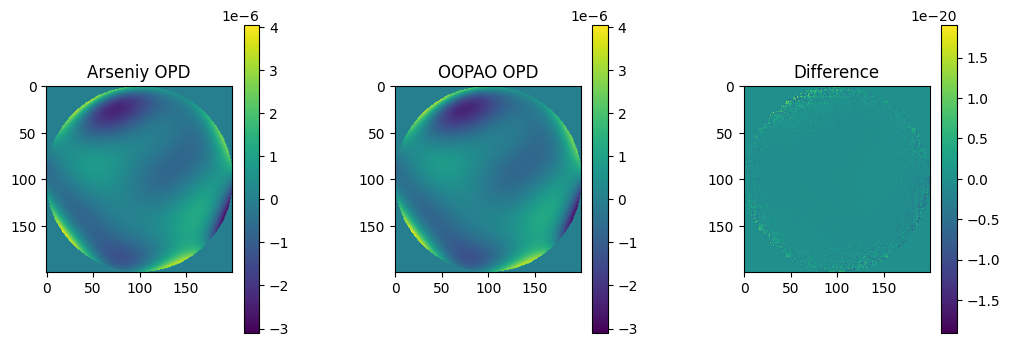

In [11]:
# with OOPAO

# create the Telescope object
tel_OOPAO = Telescope_OOPAO(resolution = 200, diameter = 10, centralObstruction = 0)

src_OOPAO = Source_OOPAO(optBand = 'H', magnitude = 10.0) 
src_OOPAO*tel_OOPAO

#%% -----------------------     ZERNIKE    ----------------------------------
nModes = 100                # number of zernike to compute

#create a zernike object
Z_OOPAO = Zernike_OOPAO(telObject = tel_OOPAO, J = nModes)

# compute the zernike polynomials associated to the telescope tel
Z_OOPAO.computeZernike(tel_OOPAO)

amp = np.zeros(nModes)

max_abs = 300e-9
number_modes = 25
amp[:number_modes] = np.random.uniform(-max_abs, max_abs, number_modes)

tel_OOPAO.OPD = np.squeeze(Z_OOPAO.modesFullRes@amp)

# With Atseniy code

D = 10.0 # [m]
resolution = 200 # telescope resolution (pupil sampling)

pixel_size = 18e-6 # [m]
ang_pixel = 50 # [mas]
f = pixel_size / ang_pixel * 206264806.71915 # [m]
print(f)

# Let's imagine we have DITs (detector integration times) of 10 frames with a total of 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.1 # [s]
num_samples = 10

# If the number of pixels in image is odd, the code will automatically center generated PSFs it to one pixel in the middle
tel = Telescope(img_resolution        = 17,  # img_resolution - Sampling of the telescope's PSF
                    pupil             = mask_circle(resolution, resolution/2, center=(0,0), centered=True),
                    diameter          = D,
                    focalLength       = f,
                    pupilReflectivity = 1.0,
                    gpu_flag          = False)

ngs = Source([('H', 10.0)]) # Initialize a target of H_mag=10
ngs * tel # attach the source to the telescope

print('Source spectrum')
print(ngs.spectrum)
print(tel.src.spectrum)

# Initialize modal basis
Z_basis = Zernike(modes_num = 100)
Z_basis.computeZernike(tel)

tel.src.OPD = Z_basis.wavefrontFromModes(tel,amp)

# plt.imshow(tel.src.OPD)
# plt.colorbar()
# plt.show()

OPD_difference = tel.src.OPD - tel_OOPAO.OPD

make_3_plot_graph(tel.src.OPD,"Arseniy OPD",tel_OOPAO.OPD,"OOPAO OPD",OPD_difference,"Difference")

## Binning functions comparison
 - the variables needed to call the function are different, but they are performing exactly the same thing

In [5]:
from tools.misc import binning
from OOPAO.tools.tools import bin_ndarray

In [6]:
print("Initial array")
m = np.random.random((10, 10))
print(m)

print("Binning with function from OOPAO")
n1 = bin_ndarray(m, new_shape=(int(10/2),int(10/2)), operation='sum')
print(n1)
print("Binning with function from Arseniy")
n2 = binning(m, 2)
print(n2)

print("Difference")
print(n2-n1)

# They are giving the same results

Initial array
[[0.4225045  0.7060536  0.25105728 0.31709815 0.08159326 0.80243079
  0.42882987 0.20868939 0.28995947 0.10512524]
 [0.78254664 0.43588875 0.07943105 0.47429584 0.00103444 0.50618987
  0.96405646 0.73601243 0.4359667  0.44731409]
 [0.77914917 0.54793514 0.39277841 0.5475165  0.55237554 0.13730928
  0.62461755 0.18855439 0.56780372 0.08367022]
 [0.60491728 0.87742327 0.01299481 0.10392542 0.53430478 0.06945192
  0.85142805 0.4251302  0.67336783 0.66912955]
 [0.19136551 0.11163693 0.24699021 0.79332883 0.94838208 0.6476803
  0.26956125 0.06329096 0.03556878 0.83544706]
 [0.35677095 0.51345609 0.46304098 0.59013932 0.22220231 0.88043683
  0.02936472 0.66265599 0.29599684 0.04950402]
 [0.97922952 0.1453199  0.51141777 0.07920191 0.83845142 0.34159379
  0.26801041 0.03811623 0.17253891 0.75776656]
 [0.02507448 0.84201129 0.36503558 0.53724193 0.92321586 0.28928614
  0.40777066 0.63861683 0.76332169 0.77583884]
 [0.69300757 0.16629336 0.03871841 0.33648019 0.61494406 0.54573943

## Reaching wavelength from source

In [7]:
print("wavelength")
print(tel_OOPAO.src.wavelength) # m
print("bandwith")
print(tel_OOPAO.src.bandwidth) # m
print("flux")
print(tel_OOPAO.src.nPhoton)  # number of photon per m2 per s

print(ngs.spectrum)

wavelength
1.654e-06
bandwith
2.9e-07
flux
298913.04347826086
[{'wavelength': 1.654e-06, 'bandwidth': 2.9e-07, 'flux': 298913.04347826086}]


## FluxMap

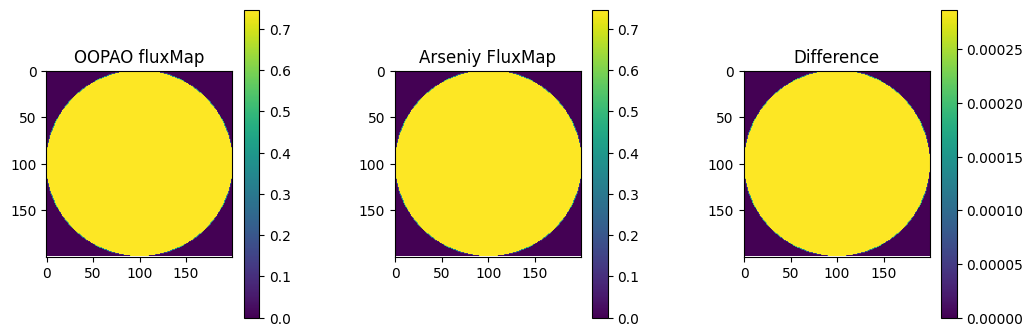

In [9]:
make_3_plot_graph(tel_OOPAO.src.fluxMap,"OOPAO fluxMap",tel.flux(ngs.spectrum[0]['flux'], 0.001)*tel.pupil,"Arseniy FluxMap",\
                  tel_OOPAO.src.fluxMap-tel.flux(ngs.spectrum[0]['flux'], 0.001)*tel.pupil,"Difference")

## self.modesFullRes

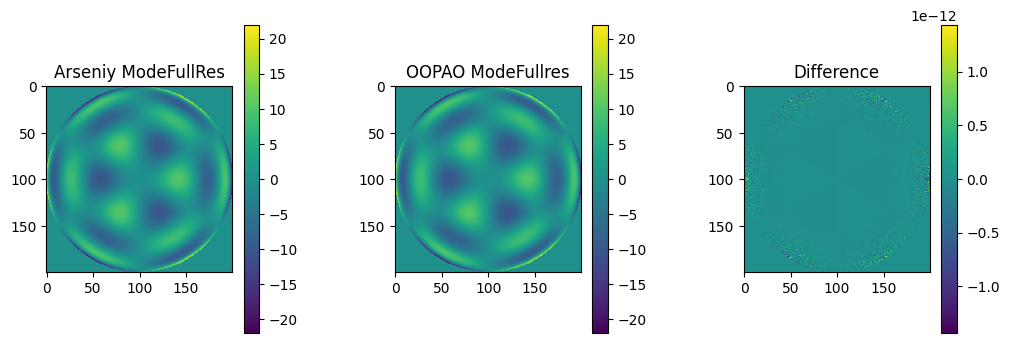

In [12]:
estimator = LIFT(tel, Z_basis, 200e-9, 20)

a = estimator.modeBasis.modesFullRes[:,:,47]*5

b = np.squeeze(Z_OOPAO.modesFullRes[:,:,47])*5

make_3_plot_graph(a,"Arseniy ModeFullRes",b,"OOPAO ModeFullres",\
                  a-b,"Difference")

## PSF computation and field propagation

In [10]:
print(0.5*(1.654e-06)/D*206264806.71915)

17.058099515673703


17.058
217.65544149048543
-------------------- TELESCOPE --------------------
Diameter 			10.0 	 [m]
Pupil sampling 			200 	 [pix]
------------------------------------------------
Telescope's pupil area = 78.53981633974483 [m^2]


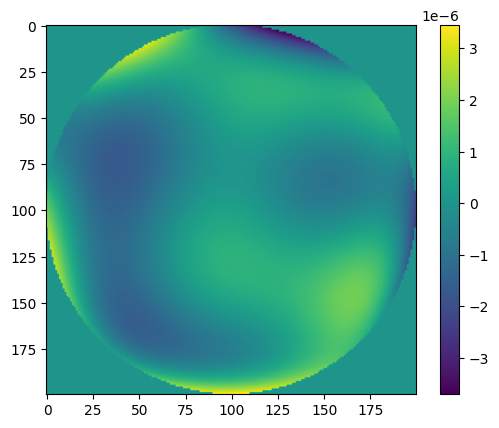

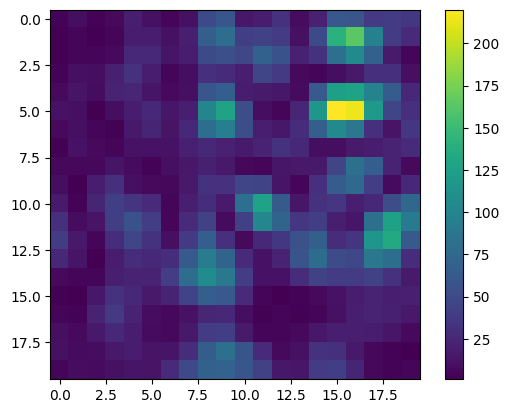

2


In [81]:
D = 10.0 # [m]
resolution = 200 # telescope resolution (pupil sampling)

pixel_size = 18e-6 # [m]
ang_pixel = 17.058 # [mas]
print(ang_pixel)
f = pixel_size / ang_pixel * 206264806.71915 # [m]
print(f)

# Let's imagine we have DITs (detector integration times) of 10 frames with a total of 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.001 # [s]
num_samples = 0

# If the number of pixels in image is odd, the code will automatically center generated PSFs it to one pixel in the middle
tel = Telescope(img_resolution        = 20,  # img_resolution - Sampling of the telescope's PSF
                    pupil             = mask_circle(resolution, resolution/2, center=(0,0), centered=True),
                    diameter          = D,
                    focalLength       = f,
                    pupilReflectivity = 1.0,
                    gpu_flag          = False)


print("Telescope's pupil area = {} [m^2]".format(tel.area))

det = Detector(pixel_size     = pixel_size,
                sampling_time = sampling_time,
                samples       = num_samples,
                RON           = 0.0, # used to generate PSF or the synthetic R_n [photons]
                QE            = 0.7) # not used

det.object = None
det * tel
ngs = Source([('H', 10.0)]) # Initialize a target of H_mag=10
ngs * tel # attach the source to the telescope

# Initialize modal basis
Z_basis = Zernike(modes_num = 100)
Z_basis.computeZernike(tel)

tel.src.OPD = Z_basis.wavefrontFromModes(tel,amp)

plt.imshow(tel.src.OPD)
plt.colorbar()
plt.show()

PSF_Arseniy = tel.ComputePSF()

plt.imshow(PSF_Arseniy)
plt.colorbar()
plt.show()


print(tel.oversampling)

In [82]:
def crop(A,N,img_size,shift_pix):

    ids = np.array([np.ceil(N/2) - img_size//2+(1-N%2)-1, np.ceil(N/2) + img_size//2+shift_pix]).astype(np.int32)
    A = A[ids[0]:ids[1], ids[0]:ids[1]]

    print(np.shape(A))

    return A

def extractor(array,l):
    
    center_x = int(array.shape[0] // 2 - l/2) 
    center_y = int(array.shape[1] // 2 - l/2)
    array_extracted = array[center_x:center_x+l, center_y:center_y+l]
    
    # idx = (np.ceil(array.shape[0] / 2) - l//2 -0).astype('int')
    # idy = (np.ceil(array.shape[1] / 2) + l//2 -0).astype('int')
    # array_extracted = array[idx:idy, idx:idy]

    return array_extracted

2.000011667918127
2
2
4.000023335836254
(40, 40)


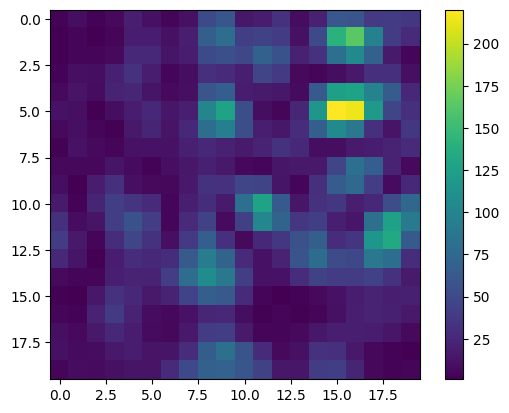

In [84]:
zeroPaddingFactor = ((ngs.spectrum[0]["wavelength"])/10) * (206264806.71915/ang_pixel)
print(zeroPaddingFactor)
print(int(zeroPaddingFactor))

oversampling = np.ceil(2/zeroPaddingFactor).astype('int')+1
# oversampling = 2
print(oversampling)

print(zeroPaddingFactor*oversampling)

tel_OOPAO.computePSF(zeroPaddingFactor*oversampling)

PSF_cropped = extractor(tel_OOPAO.PSF,np.ceil(20*oversampling).astype('int'))

PSF_binned_cropped = bin_ndarray(PSF_cropped,(20,20),'sum')
print(np.shape(PSF_cropped))
# PSF_binned_cropped = binning(PSF_cropped,oversampling)

plt.imshow(PSF_binned_cropped)
plt.colorbar()
plt.show()

In [85]:
test_1 = np.fix(zeroPaddingFactor * oversampling * resolution).astype('int')
print(test_1)

print(int(zeroPaddingFactor*oversampling*resolution))

print(np.ceil(50*oversampling))

print(7//2)

print(1364//2)
print(np.ceil((1364-200)/2).astype('int'))

800
800
100.0
3
682
582


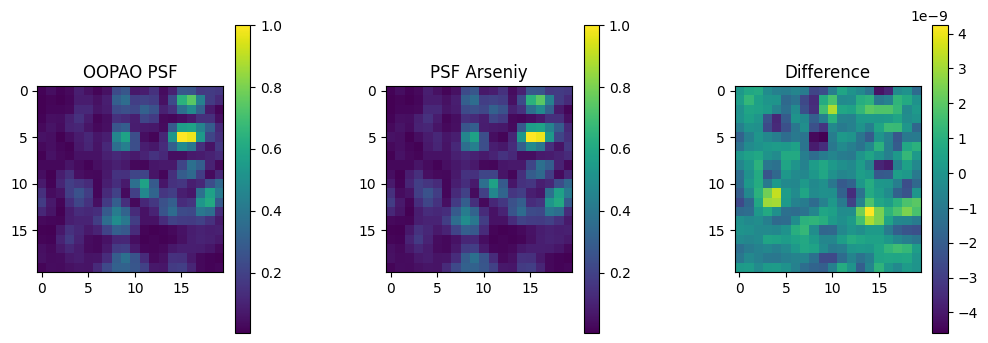

In [86]:
make_3_plot_graph(PSF_binned_cropped/np.max(PSF_binned_cropped),"OOPAO PSF",PSF_Arseniy/np.max(PSF_Arseniy),"PSF Arseniy",\
                  PSF_binned_cropped/np.max(PSF_binned_cropped)-PSF_Arseniy/np.max(PSF_Arseniy),"Difference")

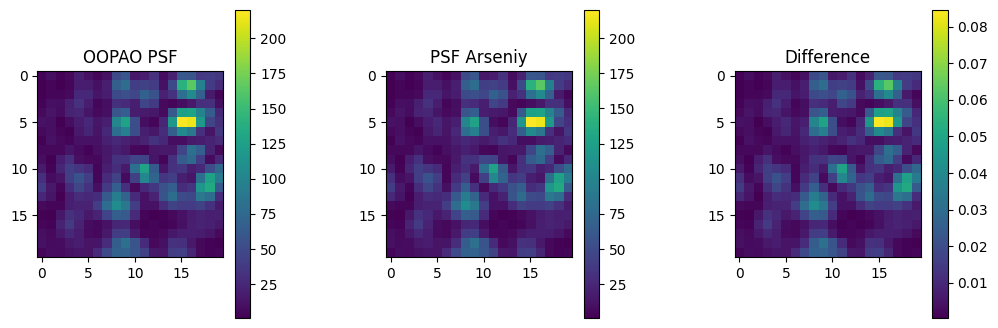

In [87]:
make_3_plot_graph(PSF_binned_cropped,"OOPAO PSF",PSF_Arseniy,"PSF Arseniy",\
                  PSF_binned_cropped-PSF_Arseniy,"Difference")

In [17]:
print(np.max(PSF_binned_cropped))
print(np.max(PSF_Arseniy))

print((10/200)**2/(tel.area/(tel.pupil.sum())))

6057.760897054405
6055.433908646583
1.0003843102984173


In [18]:
print(19%2)

1


## Propagate field

In [19]:
def Propagate_field(zeroPaddingFactor,amplitude,phase):

    N = int(zeroPaddingFactor*tel_OOPAO.resolution)

    center  = N//2           
    norma   = N
    mask = 1
    amp_mask = 1

    # zeroPadded support for the FFT
    supportPadded = np.zeros([N,N],dtype='complex')
    supportPadded [center-tel_OOPAO.resolution//2:center+tel_OOPAO.resolution//2,center-tel_OOPAO.resolution//2:center+tel_OOPAO.resolution//2] \
    = amp_mask*tel_OOPAO.pupil*tel_OOPAO.pupilReflectivity*amplitude*np.exp(1j*phase)
    [xx,yy]                         = np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,N-1,N))
    tel.phasor                     = np.exp(-(1j*np.pi*(N+1)/N)*(xx+yy))
    # tel.phasor = np.exp(-1j*np.pi/N * (xx+yy) * (1-2%2))

    EMF = np.fft.fft2(np.fft.fftshift(supportPadded*tel.phasor))*mask/norma
    # EMF = np.fft.fft2(supportPadded*tel.phasor)*mask/norma

    return EMF # electromagnetic field

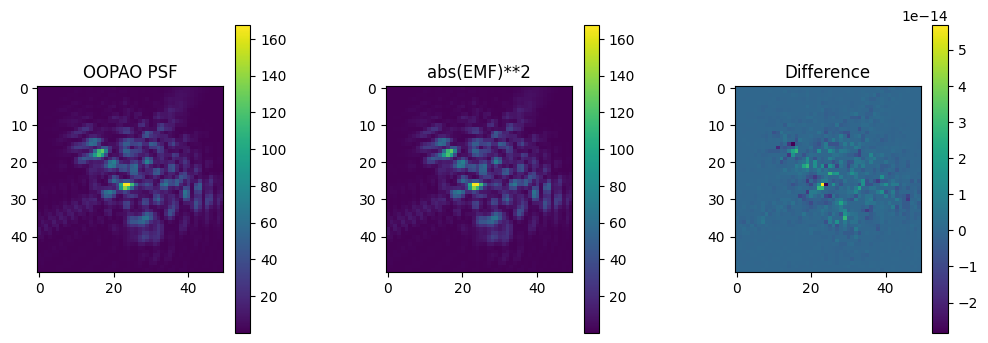

In [20]:
initial_amplitude = np.sqrt(tel_OOPAO.src.fluxMap)

k = 2*np.pi/tel_OOPAO.src.wavelength
initial_phase = k * tel_OOPAO.OPD

res = Propagate_field(zeroPaddingFactor*oversampling,amplitude=initial_amplitude,phase=initial_phase)

testar = extractor(res,50*oversampling)

# testar = crop(res,np.fix(zeroPaddingFactor * oversampling * resolution).astype('int'),np.ceil(50*oversampling).astype('int'),shift_pix=1)

# plt.imshow(extractor(np.real(res),np.ceil(40*oversampling)))
# plt.colorbar()
# plt.show()

# plt.imshow(extractor(np.imag(res),np.ceil(40*oversampling)))
# plt.colorbar()
# plt.show()

# plt.imshow(np.abs(res)**2)
# plt.colorbar()
# plt.show()

# plt.imshow(binning(np.abs(extractor(res,40*oversampling))**2,oversampling))
# plt.colorbar()
# plt.show()

make_3_plot_graph(PSF_binned_cropped,"OOPAO PSF",binning(np.abs(extractor(res,50*oversampling))**2,oversampling),"abs(EMF)**2",\
                  PSF_binned_cropped-binning(np.abs(extractor(res,50*oversampling))**2,oversampling),"Difference")

In [21]:
res1 = tel.PropagateField(amplitude=np.sqrt(tel_OOPAO.src.fluxMap), phase=tel_OOPAO.src.phase, wavelength=tel_OOPAO.src.wavelength, \
                          return_intensity=False, oversampling=None)

print(tel.oversampling)

2


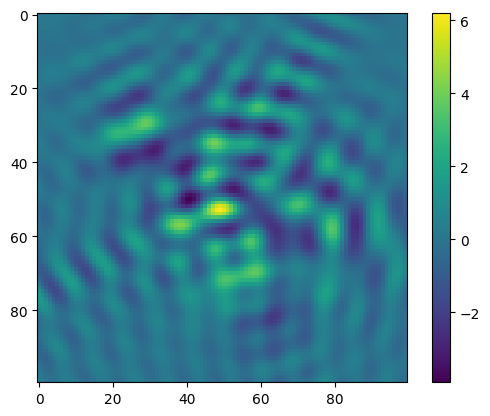

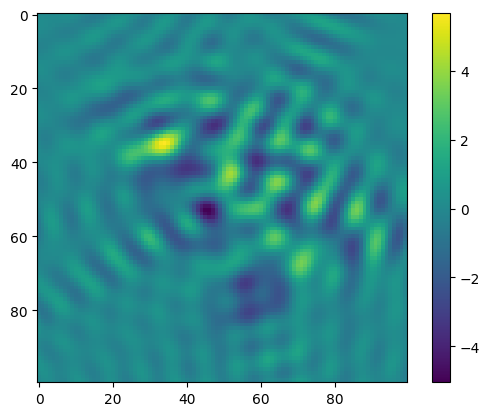

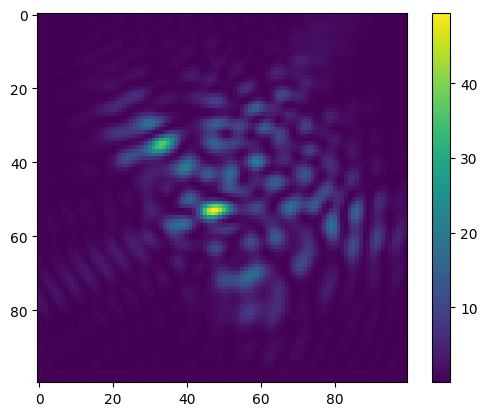

In [22]:
plt.imshow(np.real(res1))
plt.colorbar()
plt.show()

plt.imshow(np.imag(res1))
plt.colorbar()
plt.show()

plt.imshow(np.abs(res1)**2)
plt.colorbar()
plt.show()

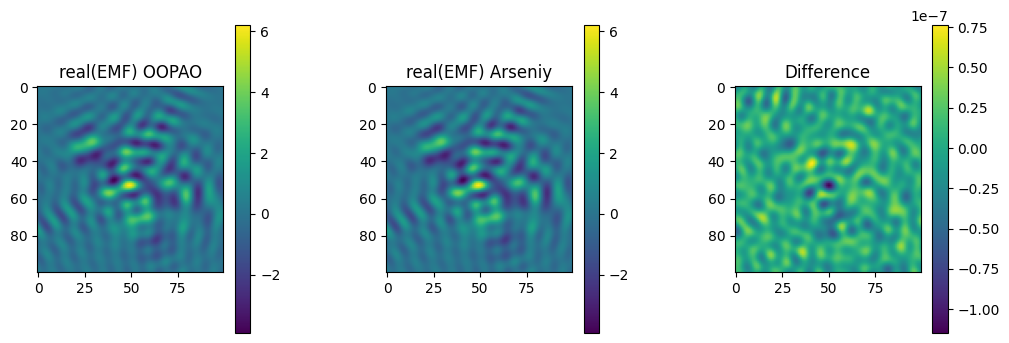

In [23]:
make_3_plot_graph(np.real(testar),"real(EMF) OOPAO",np.real(res1),"real(EMF) Arseniy",\
                  np.real(testar)-np.real(res1),"Difference")